In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# Load Data

data_path = '/content/drive/My Drive/Data/Baggage_United.csv'

bag_dat = pd.read_csv(data_path)

bag_dat.head
bag_dat.info()
print(bag_dat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Airline    84 non-null     object
 1   Date       84 non-null     object
 2   Month      84 non-null     int64 
 3   Year       84 non-null     int64 
 4   Baggage    84 non-null     int64 
 5   Scheduled  84 non-null     int64 
 6   Cancelled  84 non-null     int64 
 7   Enplaned   84 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 5.4+ KB
   Airline    Date  Month  Year  Baggage  Scheduled  Cancelled  Enplaned
0   United  Jan-04      1  2004    25015      45809       1017   4434315
1   United  Feb-04      2  2004    16660      42675        312   4458657
2   United  Mar-04      3  2004    19318      46512        321   5302929
3   United  Apr-04      4  2004    15638      45309        162   5288871
4   United  May-04      5  2004    19302      46630        652   5408451
..     ...     ...  

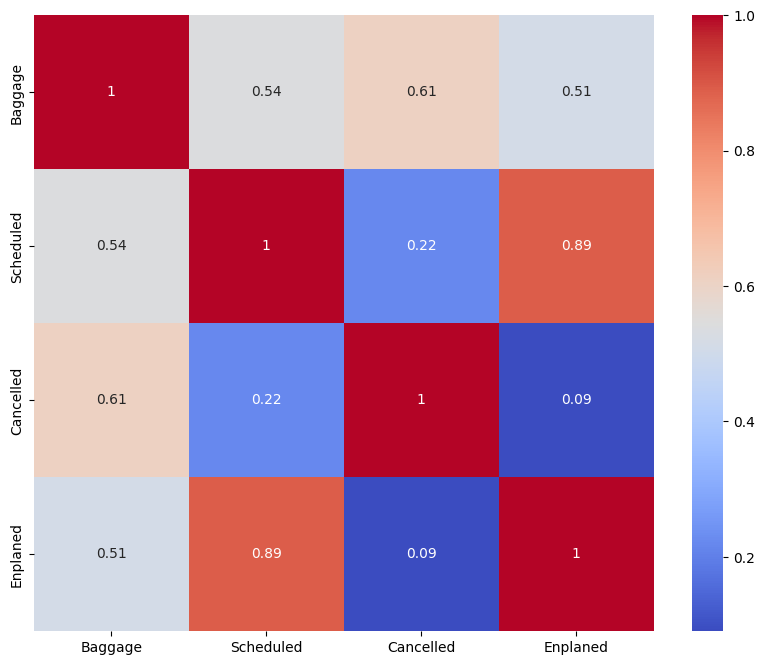

In [96]:
bag_dat_sub = bag_dat.drop(columns=['Airline', 'Date', 'Month', 'Year'])


# Compute correlations
cormat = bag_dat_sub.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

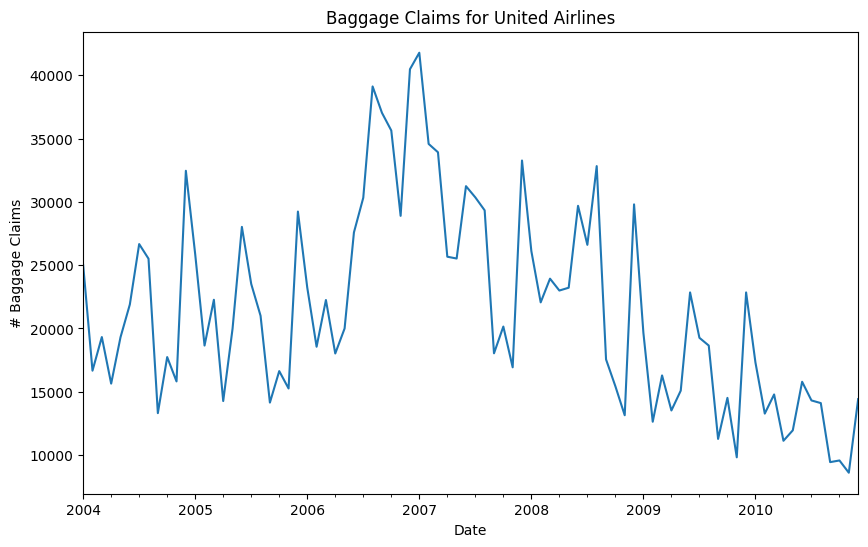

In [97]:
# Convert date column to a date class variable

# Create a monthly index for the series
bag_dat['Date'] = pd.to_datetime(bag_dat['Date'], format="%b-%y")
bag_ts = pd.Series(bag_dat['Baggage'].values, index=bag_dat['Date'])

bag_ts.index.freq = 'MS'


#Plot the series
plt.figure(figsize=(10, 6))
bag_ts.plot()
plt.title("Baggage Claims for United Airlines")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.show()

In [98]:
#execute the Ljung Box test on the Coffee series using 10 lags
Bags = bag_dat[['Baggage']]

sm.stats.acorr_ljungbox(Bags, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,160.317171,2.786746e-29


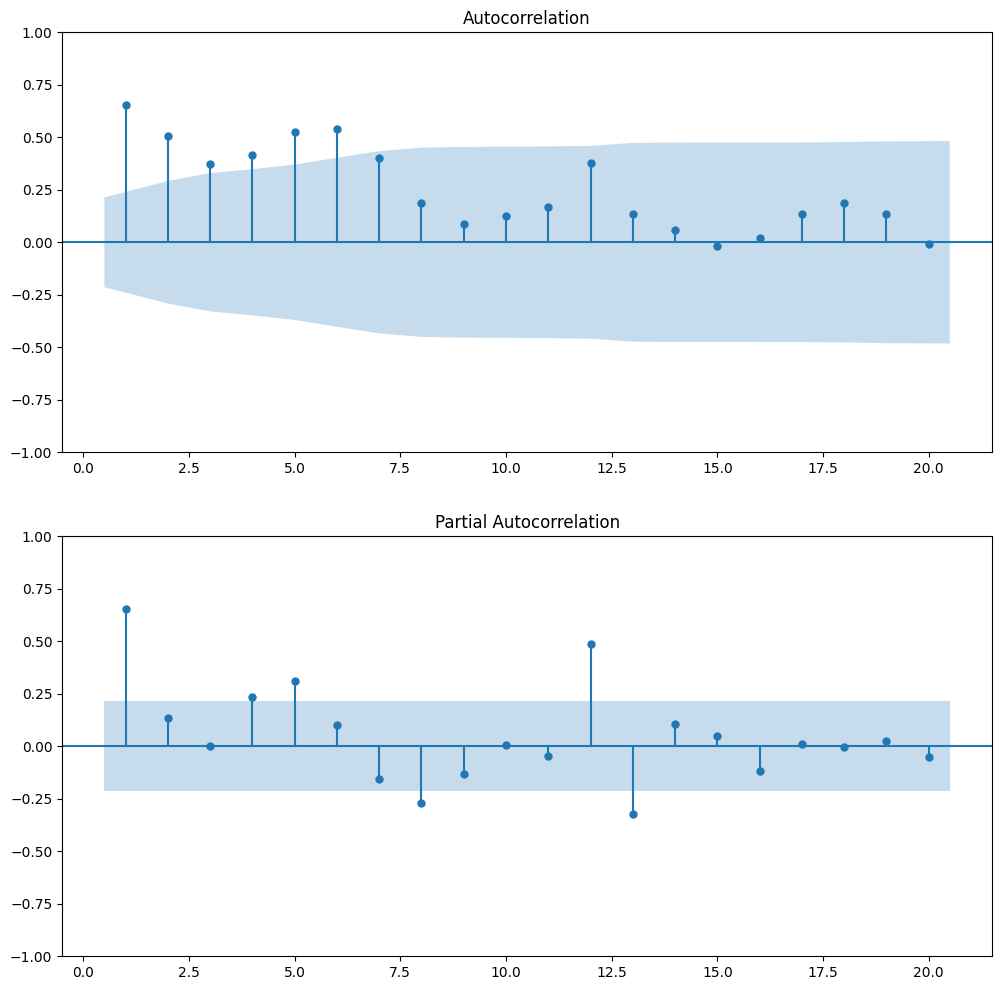

In [99]:
#Plot the ACF and PACF for the coffee series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(bag_ts, ax=ax1, zero=False)
plot_pacf(bag_ts, ax=ax2, zero=False)
plt.show()

For seasonal time series, the first step in the process is taking a seasonal difference.  To do this, you need to include the seasonal_order(P,D,Q,s) option when you run the ARIMA procedure.  P is the number of seasonal AR terms, Q is the number of seasonal MA terms, s is the length of the seasonal period (for example, s=12 if it takes 12 months to complete the seasonal cycle).  To take a seasonal difference set D=1.

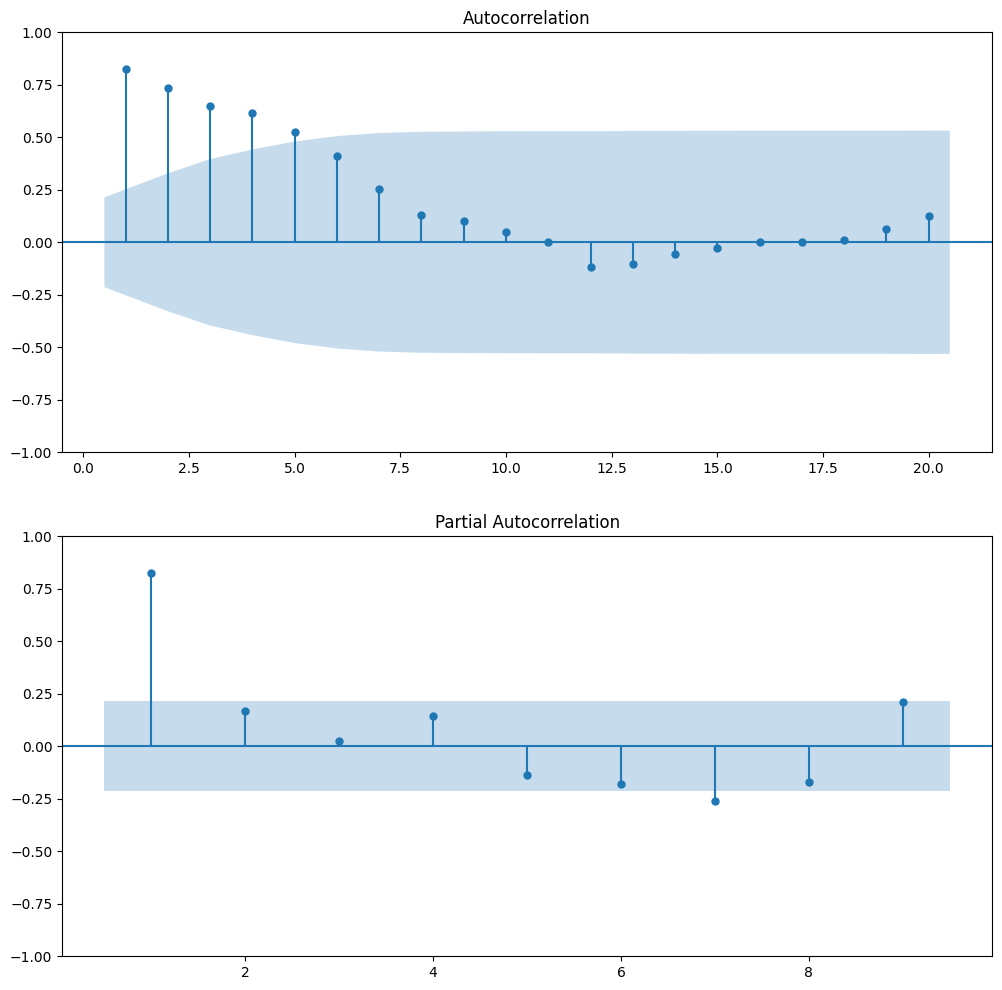

In [100]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(bag_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()


Notice that the ACF and PACF for the residuals look like a typical autoregressive signature, so the next step might be to add p = 1 to include an AR(1) term in the model.  This will not be sufficient to get the residuals to white noise.  Recall that an MA term can help to smooth out a model after differencing.  In this case we took a seasonal difference, so we'll include a seasonal MA term by setting Q=1 in the seasonal order.

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -706.585
Date:                            Wed, 11 Oct 2023   AIC                           1419.170
Time:                                    16:06:38   BIC                           1426.000
Sample:                                01-01-2004   HQIC                          1421.890
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8258      0.035     23.635      0.000       0.757       0.894
ma.S.L12      -0.6496      0.116   

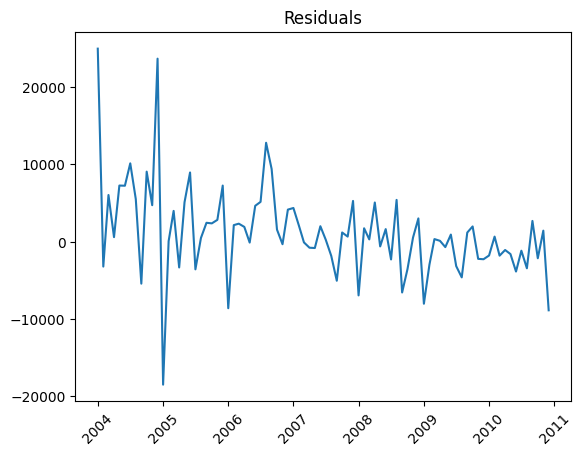

In [101]:
# Fit ARIMA(1,0,0)x(0,1,1)[12] model to the data

#Best model for Baggage Complaints for United is ARIMA(1,0,0)x(0,1,1)[12]
fit_AR1 = ARIMA(bag_ts, order=(1,0,0), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR1.get_prediction()
print(pred_units)


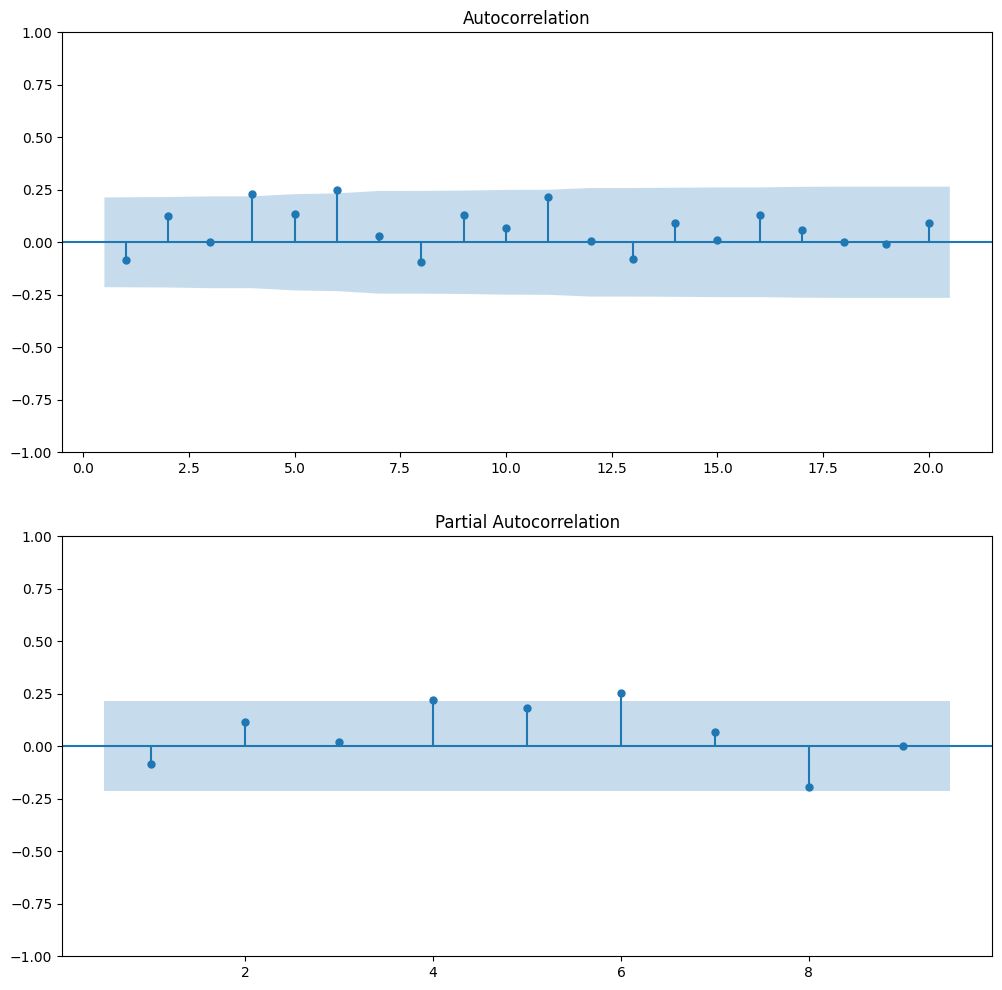

In [102]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()


After reviewing the ACF and PACF for the resiuals from this model and noticing that the Ljung Box test (below) indicates that the residuals are white noise, this seems to be a reasonable model for the data.

In [103]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,16.951913,0.075435


Convert predictions into a data frame in order to compute the forecast error

In [104]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
2004-02-01,19898.744014,9639.203017,30158.285011
2004-03-01,13278.758482,3019.242911,23538.274052
2004-04-01,15061.243589,4805.267095,25317.220083
2004-05-01,12035.958696,1785.483779,22286.433612
2004-06-01,14649.272687,4406.927829,24891.617545


Join actual values to predicted values

In [105]:
# add back actuals --
prediction_df = pd.concat([prediction_df,bag_ts.to_frame(name='Baggage')],axis=1)
prediction_df = prediction_df.tail(-1)
prediction_df.head()




,predicted_mean,lower_bound,upper_bound,Baggage
Date,,,,
2004-02-01,19898.744014,9639.203017,30158.285011,16660
2004-03-01,13278.758482,3019.242911,23538.274052,19318
2004-04-01,15061.243589,4805.267095,25317.220083,15638
2004-05-01,12035.958696,1785.483779,22286.433612,19302
2004-06-01,14649.272687,4406.927829,24891.617545,21892


Calculate the Forecast Error

In [106]:
# calc error
errors = prediction_df['Baggage'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['Baggage'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')


MAPE = 17.942%
RMSE = 5,462.825


Generate the forecast for the next six months

In [107]:
# Generate forecast for the next six months
forecast = fit_AR1.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_CPI': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

,Forecasted_CPI,Lower_Bound,Upper_Bound
2011-01-01,11517.989987,3166.755574,19869.224401
2011-02-01,8070.936387,-2757.702057,18899.574831
2011-03-01,11672.924016,-560.511295,23906.359327
2011-04-01,9262.037189,-3843.209135,22367.283512
2011-05-01,11463.779642,-2204.058916,25131.618201
2011-06-01,17903.990424,3865.490787,31942.490060


Plot the series and append the six month forecast.  Notice that the forecast follows a pattern similar to the one observed in the actual data

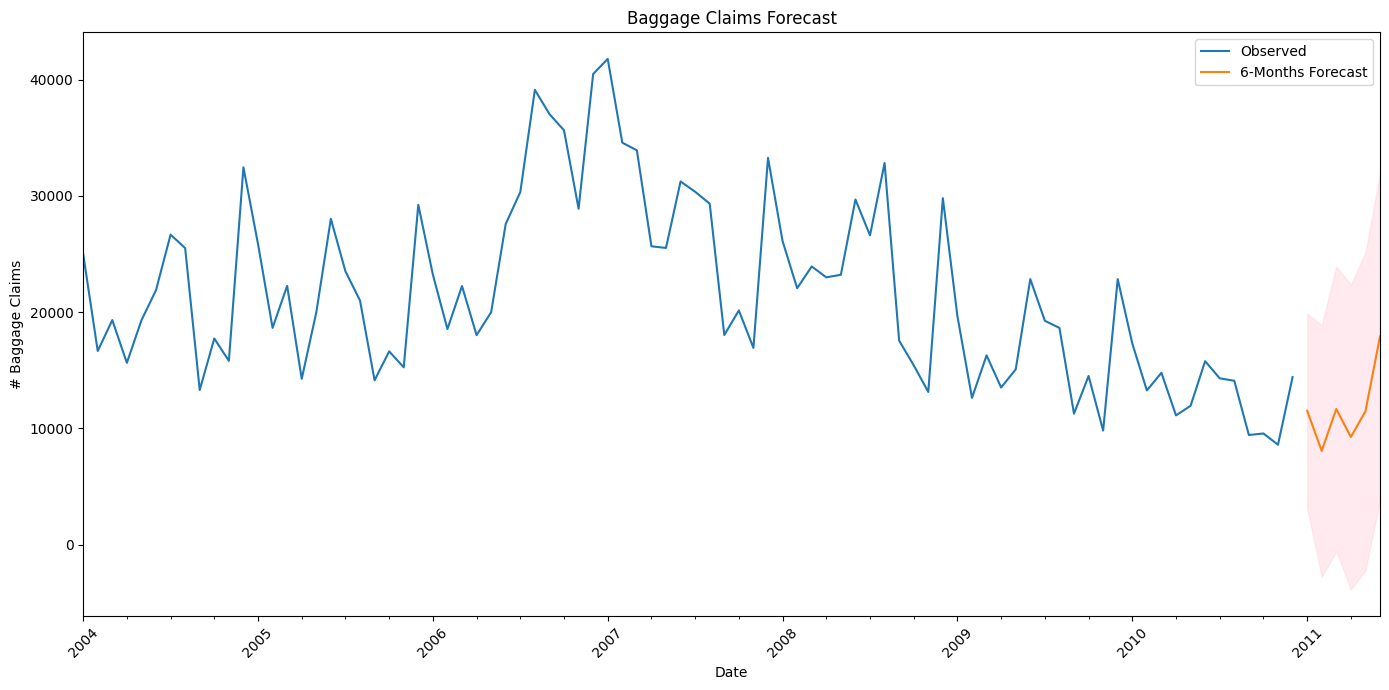

In [108]:

# Plot forecast
plt.figure(figsize=(14, 7))
bag_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Baggage Claims Forecast")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()